# Practical Case study: **Definition Modeling** and **Evaluation of Generative tasks**

Definition modeling ([Noraset, 2017](https://arxiv.org/abs/1612.00394)): the task of generating dictionary-like definitions given a word, eventually in context (Contextual Definition Modeling).


>  *In this paper, we study whether it is possible to utilize distributed representations to generate dictionary definitions of words, as a more direct and transparent representation of the embeddings' semantics.*

Born as an interpretability approach, it's a challenging task with many nuances and use cases, for example:
- Word Sense Disambiguation (WSD)
- Automatic generation of dictionaries

It can be used to assess the information inside word embeddings, but also as the ability to infer meaning from contextual clues and word internal structure for novel words (neologisms).

For example: "deskphobia" ---> "The fear of desks, figuratively the fear of working". That's an invented one, but you see the complexity...



### Remember to activate a runtime with a GPU to speed up inference!

In [101]:
#!pip install transformers
#!pip install torch

from transformers import AutoModelForCausalLM, AutoTokenizer

### Model and tokenizer Loading

In [102]:
# model card: https://huggingface.co/Qwen/Qwen2.5-0.5B-Instruct

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Load dataset

Let's load a dataset of words and definitions extracted from the [Wiktionary](https://www.wiktionary.org/) from huggingface: https://huggingface.co/datasets/leukas/Wiktionary

In [103]:
from datasets import load_dataset

dataset = load_dataset("leukas/Wiktionary") # load dataset from hf

In [104]:
print(dataset)
print("Shape:", dataset.shape)
# an example
print("An example:", dataset["train"][1000])

DatasetDict({
    train: Dataset({
        features: ['word', 'POS', 'synonyms', 'antonyms', 'hypernyms', 'glosses', 'example'],
        num_rows: 300883
    })
})
Shape: {'train': (300883, 7)}
An example: {'word': 'population', 'POS': 'noun', 'synonyms': None, 'antonyms': None, 'hypernyms': None, 'glosses': 'The people with a given characteristic.', 'example': None}


We will sample just 100 examples for our case study.

In [105]:
import random # a library for random number generation/sampling

sample_ids = [] # random ids

while len(sample_ids) < 100: # until we have 100 samples
  n = random.choice(range(0, dataset["train"].shape[0])) # we choose a number between 0 and the size of the dataset (an id)

  if dataset["train"][n]["glosses"] == None or dataset["train"][n]["example"] == None: # we make sure that the sampled example has a definition and an example
    continue

  if len(dataset["train"][n]["example"]) < 30 or len(dataset["train"][n]["glosses"]) < 100: # we take longer cases...
      continue

  if n not in sample_ids:
    sample_ids.append(n)

sampled_dataset = dataset["train"].select(sample_ids) # filter the original dataset with the sampled ids

print(sampled_dataset)

# let's print the first 15

for i in range(15):
  print(sampled_dataset[i])

Dataset({
    features: ['word', 'POS', 'synonyms', 'antonyms', 'hypernyms', 'glosses', 'example'],
    num_rows: 100
})
{'word': 'her', 'POS': 'pron', 'synonyms': 'herė', 'antonyms': None, 'hypernyms': None, 'glosses': 'The form of she used after a preposition, as the object of a verb, or (colloquial) as a subject with a conjunction; that woman, that ship, etc.', 'example': 'Give it to her (after preposition)'}
{'word': 'amphoric', 'POS': 'adj', 'synonyms': None, 'antonyms': None, 'hypernyms': None, 'glosses': 'Produced by or indicating a hollow cavity in the lungs, giving a sound like that produced by blowing into an empty decanter.', 'example': '...amphoric respiration or resonance...'}
{'word': 'omnidirectional', 'POS': 'adj', 'synonyms': None, 'antonyms': 'unidirectional', 'hypernyms': None, 'glosses': 'In every direction, especially of a radio system capable of transmitting or receiving signals in all directions, or of a microphone capable of detecting sound from all directions.'

## Dataset preparation, text formatting and generation

Given the dataset we prepare inputs and correct references in the following format:
- inputs: "Define *word*, *pos*, given the following example: *example*
- references: *definition*

Greedy generation is deterministic!

In [106]:
inputs = [] # model inputs
references = [] # references

for row in sampled_dataset:
  references.append(row["glosses"])
  prompt = f"Generate a short dictionary definition of the word '{row["word"]}' ({row["POS"]})" # prompt definition
  if row["example"] != None:
    prompt += f", given the following example: {row["example"]}."
  else:
    prompt+="."

  messages = [
      {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the definition directly."},
      {"role": "user", "content": prompt}
  ]
  text = tokenizer.apply_chat_template( # chat template: this model is already instruction tuned with a specfic system prompt
      messages,
      tokenize=False,
      add_generation_prompt=True
  )
  inputs.append(text)


model_inputs = tokenizer(inputs, return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)


generation_config = {"max_new_tokens": 32, "do_sample": False} # greedy
generated_ids = model.generate(
    **model_inputs,
    **generation_config
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids) # we extract only the generated text excluding the prompt
]

responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

In [107]:
responses[:5]

['The word "her" in this context refers to the female gender.',
 'Amphoric refers to something that is composed of two parts connected in such a way as to form a single unit.',
 'An omnidirectional radio beacon is a device that can be used to transmit signals in all directions simultaneously, allowing for wide-ranging communication and coverage.',
 'The verb "authorize" means to grant permission or approval for something to be done or used. It is typically used in legal contexts to indicate that someone has granted',
 'The verb "belittle" means to treat someone or something with contempt or low regard. It implies that one is not impressed or appreciative of another\'s abilities']

Predictions are not well aligned with the style of dictionary definitions. In this case we can try several approaches:
- Few-shot (provide some solved example in the prompt)
- Change the prompt
- Train the model on a small set of word-definitions pairs just to teach the task (take a look at: https://huggingface.co/docs/trl/en/sft_trainer)

## Let's evaluate...
... accuracy won't work for generation tasks. We have some options. Traditional metrics:

- **Rouge**
-  Bleu
- CER, WER

Or trained ones (use other neural networks):
- Comet
- BertScore
- **SBERT** (as a similarity score)


It's a well known fact that generation is difficult to evaluate (there are different correct ways of saying the same correct thing!) and traditional metrics can suggest a trend, but are not enough, see: "[How not to evaluate your dialogue system:
An empirical study of unsupervised evaluation metrics for dialogue response generation](https://arxiv.org/abs/1603.08023)"


[Rouge](https://huggingface.co/spaces/evaluate-metric/rouge) (Recall-Oriented Understudy for Gisting Evaluation): a set of metrics and a software package specifically designed for evaluating automatic summarization, but that can be also used for other tasks. It measures lexical overlap, values are in the range of 0 to 1.

Rouge-N: overlap of n-grams between the model and reference texts:

(C = Candidate, R = Reference)

ROUGE-1 precision can be computed as the ratio of the number of unigrams in C that appear also in R over the number of unigrams in C.

ROUGE-1 recall can be computed as the ratio of the number of unigrams in R that appear also in C over the number of unigrams in .

ROUGE-1 f1-score is the harmonic mean of the two.

In [15]:
!pip install evaluate
!pip install rouge_score
import evaluate
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=106c5e5f03070c939bdb7b6d9c8f58372e459081e6bc8f8d2368d109fcdc9ce1
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [108]:
rouge = evaluate.load('rouge') # metric loading

results = rouge.compute(predictions=responses, references=references, tokenizer=tokenizer.tokenize) # it returns f1-scores
print("Greedy search:\n", results)

Greedy search:
 {'rouge1': np.float64(0.21407972447227486), 'rouge2': np.float64(0.03451581781174009), 'rougeL': np.float64(0.1616270740975391), 'rougeLsum': np.float64(0.16185142982056994)}


### Let's try nucleus sampling...

... it's not deterministic!

So, a good practice is to do multiple runs and report the average performance and the standard deviation

In [109]:
per_run_results = {} # here we collect the results of 5 runs

for run in range(5):
  inputs = []
  references = []

  for row in sampled_dataset:
    references.append(row["glosses"])
    prompt = f"Generate a short dictionary definition of the word '{row["word"]}' ({row["POS"]})"
    if row["example"] != None:
      prompt += f", given the following example: {row["example"]}."
    else:
      prompt+="."

    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    inputs.append(text)


  model_inputs = tokenizer(inputs, return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)

  # nucleus sampling
  generation_config = {"max_new_tokens": 32, "do_sample": True, "top_p": 0.92, "temperature": 0.4}
  generated_ids = model.generate(
      **model_inputs,
      **generation_config
  )
  generated_ids = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

  responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  results = rouge.compute(predictions=responses, references=references) # rouge
  print(f"Run {run} results:\n", results)
  per_run_results[run] = results # we store the run results


for metric_name in per_run_results[0]: # for each metric
  results = []
  for run in per_run_results:
    results.append(per_run_results[run][metric_name])
  print(f"Avg. {metric_name}: {np.mean(results)},  Std. : {np.std(results)}") # average and std

Run 0 results:
 {'rouge1': np.float64(0.2118868471264947), 'rouge2': np.float64(0.028509739790737586), 'rougeL': np.float64(0.15690592988999935), 'rougeLsum': np.float64(0.15866712167522912)}
Run 1 results:
 {'rouge1': np.float64(0.22017986749942847), 'rouge2': np.float64(0.03662395676728556), 'rougeL': np.float64(0.16682660949291073), 'rougeLsum': np.float64(0.16718441360122405)}
Run 2 results:
 {'rouge1': np.float64(0.21640490783855815), 'rouge2': np.float64(0.028232369366019423), 'rougeL': np.float64(0.16064593859911297), 'rougeLsum': np.float64(0.16465075155089404)}
Run 3 results:
 {'rouge1': np.float64(0.1972231022308072), 'rouge2': np.float64(0.028732325825116825), 'rougeL': np.float64(0.14887047398298514), 'rougeLsum': np.float64(0.14897096629908801)}
Run 4 results:
 {'rouge1': np.float64(0.2244036439252809), 'rouge2': np.float64(0.03209650265283372), 'rougeL': np.float64(0.16849716405174925), 'rougeLsum': np.float64(0.1702519255708537)}
Avg. rouge1: 0.21401967372411387,  Std. :

In [110]:
for prompt, res, gold in zip(inputs[:5], responses[:5], references[:5]):
  print(f"{prompt} --- {res} --- {gold}")

<|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary.<|im_end|>
<|im_start|>user
Generate a short dictionary definition of the word 'her' (pron), given the following example: Give it to her (after preposition).<|im_end|>
<|im_start|>assistant
 --- Her is an article of personal address used as a demonstrative pronoun in English, indicating possession or reference to a specific person. It can be used with either --- The form of she used after a preposition, as the object of a verb, or (colloquial) as a subject with a conjunction; that woman, that ship, etc.
<|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary.<|im_end|>
<|im_start|>user
Generate a short dictionary definition of the word 'amphoric' (adj), given the following example: ...amphoric respiration or resonance....<|im_end|>
<|im_start|>assistant
 --- **Definition:** Amphoric is an adjective that describes something

## Let's define a small toy dataset of neologisms to see if the performance hold



In [111]:
neo_dataset = [
    {"word": "Climavore", "POS": "noun", "glosses": "someone who chooses their diet based on the impact of food production on the climate", "example": "As a climavore, she eats a diet of food which is resilient to climate change, like seaweed."},
    {"word": "wellbeing washing ", "POS": "noun phrase", "glosses": "behaviour or activities designed to make people think a company supports the physical and mental health of its employees, when it actually gives them very little real help", "example": "A Institution of Occupational Safety and Health study found that 51% of employees believe their employer engages in wellbeing washing"},
    {"word": "Mid", "POS": "adj", "glosses": "something that is average or not very special.", "example": "That pilates class was so mid"},
    {"word": "friendflation", "POS": "noun", "glosses": " the rising cost of going out with friends", "example": "Can you put a price on friendship? Apparently you can, and it isn’t cheap. The rising cost of socialising, known as friendflation"},
    {"word": "hopecore", "POS": "noun", "glosses": "a style of online content that features positive, optimistic images and messages", "example": "Hopecore; one of the most prominent trends on TikTok during what many see as a dark time both politically and socially"},
]

In [112]:
inputs = []
references = []

for row in neo_dataset:
  references.append(row["glosses"])
  prompt = f"Generate a short dictionary definition of the word '{row["word"]}' ({row["POS"]})"
  if row["example"] != None:
    prompt += f", given the following example: {row["example"]}"

  messages = [
      {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary."},
      {"role": "user", "content": prompt}
  ]
  text = tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )
  inputs.append(text)


model_inputs = tokenizer(inputs, return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)


generation_config = {"max_new_tokens": 32, "do_sample": False}
generated_ids = model.generate(
    **model_inputs,
    **generation_config
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

results = rouge.compute(predictions=responses, references=references, tokenizer=tokenizer.tokenize)
print("Greedy search:\n", results)

for prompt, res, gold in zip(inputs[:5], responses[:5], references[:5]):
  print(f"{prompt} --- {res} --- {gold}")

Greedy search:
 {'rouge1': np.float64(0.13662658032685784), 'rouge2': np.float64(0.010526315789473686), 'rougeL': np.float64(0.110354609929078), 'rougeLsum': np.float64(0.11152875175315569)}
<|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary.<|im_end|>
<|im_start|>user
Generate a short dictionary definition of the word 'Climavore' (noun), given the following example: As a climavore, she eats a diet of food which is resilient to climate change, like seaweed.<|im_end|>
<|im_start|>assistant
 --- **Definition:** A person who engages in or prefers activities that are adapted to survive and thrive under changing environmental conditions, such as those found in coastal areas or regions --- someone who chooses their diet based on the impact of food production on the climate
<|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary.<|im_end|>
<|im_start|>user
Generate a short dictio

In [113]:
# Nucleus sampling...

per_run_results = {}

for run in range(5):
  inputs = []
  references = []

  for row in neo_dataset:
    references.append(row["glosses"])
    prompt = f"Generate a short dictionary definition of the word '{row["word"]}' ({row["POS"]})"
    if row["example"] != None:
      prompt += f" given the following example: {row["example"]}"

    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    inputs.append(text)


  model_inputs = tokenizer(inputs, return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)

  # nucleus sampling
  generation_config = {"max_new_tokens": 32, "do_sample": True, "top_p": 0.92, "temperature": 0.4}
  generated_ids = model.generate(
      **model_inputs,
      **generation_config
  )
  generated_ids = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

  responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  results = rouge.compute(predictions=responses, references=references)
  print(f"Run {run} results:\n", results)
  per_run_results[run] = results


for metric_name in per_run_results[0]:
  results = []
  for run in per_run_results:
    results.append(per_run_results[run][metric_name])
  print(f"Avg. {metric_name}: {np.mean(results)},  Std. : {np.std(results)}")


for prompt, res, gold in zip(inputs[:5], responses[:5], references[:5]):
  print(f"{prompt} --- {res} --- {gold}")

Run 0 results:
 {'rouge1': np.float64(0.2073322641005079), 'rouge2': np.float64(0.01111111111111111), 'rougeL': np.float64(0.1440352284078279), 'rougeLsum': np.float64(0.1433455732354141)}
Run 1 results:
 {'rouge1': np.float64(0.1581453634085213), 'rouge2': np.float64(0.026579520697167756), 'rougeL': np.float64(0.11959706959706959), 'rougeLsum': np.float64(0.11959706959706959)}
Run 2 results:
 {'rouge1': np.float64(0.1761176279062674), 'rouge2': np.float64(0.02142857142857143), 'rougeL': np.float64(0.13762772892890748), 'rougeLsum': np.float64(0.13762772892890748)}
Run 3 results:
 {'rouge1': np.float64(0.1265497076023392), 'rouge2': np.float64(0.03358288770053476), 'rougeL': np.float64(0.12654970760233916), 'rougeLsum': np.float64(0.12654970760233916)}
Run 4 results:
 {'rouge1': np.float64(0.17506428212310565), 'rouge2': np.float64(0.023529411764705882), 'rougeL': np.float64(0.15782805429864255), 'rougeLsum': np.float64(0.15937800761330173)}
Avg. rouge1: 0.1686418490281483,  Std. : 0.0

## SBERT: Sentence Bert

 A modification of the pretrained BERT network that use a contrastive tuning strategy to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity (see: https://arxiv.org/abs/1908.10084)

 It's not a metric, but we can leverage these expressive representations to encode the prediction and the refrences into embeddings and compare them through cosine similarity.

 Cosine similarity is the typical metric used in NLP to assess how "close" two embeddings are in the vector space (i.e., how semantically similar):

 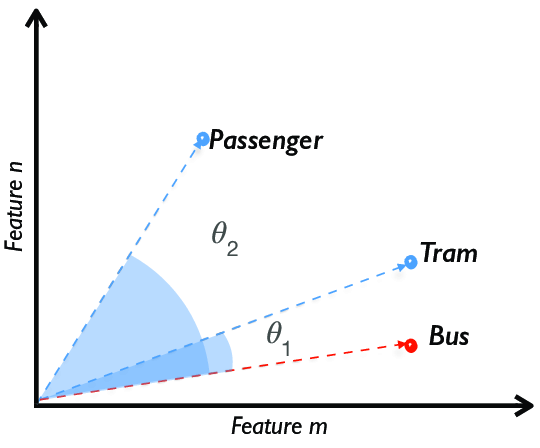

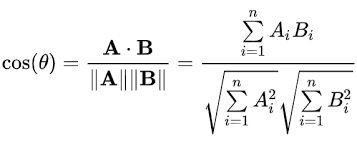

 The closer to 1 the better.

### We can easily load such models using the [Sentence Transformers](https://sbert.net/index.html) library:

In [40]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer # library import

In [114]:
sbert_model = SentenceTransformer("all-MiniLM-L6-v2") # Loading a SBERT model

# Two lists of sentences
sentences1 = [
    "The new movie is awesome",
    "The cat sits outside",
    "A man is playing guitar",
]

sentences2 = [
    "The dog plays in the garden",
    "The new movie is so great",
    "A woman watches TV",
]

# Compute embeddings for both lists
embeddings1 = sbert_model.encode(sentences1)
embeddings2 = sbert_model.encode(sentences2)

print("That's an example of an embedding:" embeddings1[0])

# Compute cosine similarities
similarities = sbert_model.similarity(embeddings1, embeddings2)

# Output the pairs with their score
for idx_i, sentence1 in enumerate(sentences1):
    print(sentence1)
    for idx_j, sentence2 in enumerate(sentences2):
        print(f" - {sentence2: <30}: {similarities[idx_i][idx_j]:.4f}")

The new movie is awesome
 - The dog plays in the garden   : 0.0543
 - The new movie is so great     : 0.8939
 - A woman watches TV            : -0.0502
The cat sits outside
 - The dog plays in the garden   : 0.2838
 - The new movie is so great     : -0.0029
 - A woman watches TV            : 0.1310
A man is playing guitar
 - The dog plays in the garden   : 0.2277
 - The new movie is so great     : -0.0136
 - A woman watches TV            : -0.0327


Now let's evaluate the predictions using SBERT and cosine similarity

In [115]:
inputs = []
references = []

for row in sampled_dataset:
  references.append(row["glosses"])
  prompt = f"Generate a short dictionary definition of the word '{row["word"]}' ({row["POS"]})"
  if row["example"] != None:
    prompt += f", given the following example: {row["example"]}."
  else:
    prompt+="."

  messages = [
      {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the definition directly."},
      {"role": "user", "content": prompt}
  ]
  text = tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )
  inputs.append(text)


model_inputs = tokenizer(inputs, return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)


generation_config = {"max_new_tokens": 32, "do_sample": False}
generated_ids = model.generate(
    **model_inputs,
    **generation_config
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

results = rouge.compute(predictions=responses, references=references, tokenizer=tokenizer.tokenize, use_aggregator = False)

# Compute embeddings for both lists
embeddings1 = sbert_model.encode(responses)
embeddings2 = sbert_model.encode(references)

# Compute cosine similarities
similarities = []
for i in range(len(responses)):
  sim = sbert_model.similarity(embeddings1[i], embeddings2[i])
  similarities.append(sim)
  if i < 10:
    print(f"Input: {inputs[i]} --- pred: {responses[i]} --- gold: {references[i]}")
    print("Similarity:", sim)
    print("Rouge-1:", results["rouge1"][i])
    print("*"*10)

Input: <|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the definition directly.<|im_end|>
<|im_start|>user
Generate a short dictionary definition of the word 'her' (pron), given the following example: Give it to her (after preposition).<|im_end|>
<|im_start|>assistant
 --- pred: The word "her" in this context refers to the female gender. --- gold: The form of she used after a preposition, as the object of a verb, or (colloquial) as a subject with a conjunction; that woman, that ship, etc.
Similarity: tensor([[0.6256]])
Rouge-1: 0.11320754716981134
**********
Input: <|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the definition directly.<|im_end|>
<|im_start|>user
Generate a short dictionary definition of the word 'amphoric' (adj), given the following example: ...amphoric respiration or resonance....<|im_end|>
<|im_start|>assistant
 --- pred: Amphoric refers to something that is composed of two parts connected in such a way as to form a single unit. -

In [116]:
results = rouge.compute(predictions=responses, references=references, tokenizer=tokenizer.tokenize)
print("Greedy search:\n", results)
print("Average cosine similarity:", np.mean(similarities))

Greedy search:
 {'rouge1': np.float64(0.21407972447227486), 'rouge2': np.float64(0.03451581781174009), 'rougeL': np.float64(0.1616270740975391), 'rougeLsum': np.float64(0.16185142982056994)}
Average cosine similarity: 0.4678558


In [117]:
inputs = []
references = []

for row in neo_dataset:
  references.append(row["glosses"])
  prompt = f"Generate a short dictionary definition of the word '{row["word"]}' ({row["POS"]})"
  if row["example"] != None:
    prompt += f", given the following example: {row["example"]}"

  messages = [
      {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary."},
      {"role": "user", "content": prompt}
  ]
  text = tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )
  inputs.append(text)


model_inputs = tokenizer(inputs, return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)


generation_config = {"max_new_tokens": 32, "do_sample": False}
generated_ids = model.generate(
    **model_inputs,
    **generation_config
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

results = rouge.compute(predictions=responses, references=references, tokenizer=tokenizer.tokenize, use_aggregator = False)

# Compute embeddings for both lists
embeddings1 = sbert_model.encode(responses)
embeddings2 = sbert_model.encode(references)

# Compute cosine similarities
similarities = []
for i in range(len(responses)):
  sim = sbert_model.similarity(embeddings1[i], embeddings2[i])
  similarities.append(sim)
  if i < 10:
    print(f"Input: {inputs[i]} --- pred: {responses[i]} --- gold: {references[i]}")
    print("Similarity:", sim)
    print("Rouge-1:", results["rouge1"][i])
    print("*"*10)

Input: <|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary.<|im_end|>
<|im_start|>user
Generate a short dictionary definition of the word 'Climavore' (noun), given the following example: As a climavore, she eats a diet of food which is resilient to climate change, like seaweed.<|im_end|>
<|im_start|>assistant
 --- pred: **Definition:** A person who engages in or prefers activities that are adapted to survive and thrive under changing environmental conditions, such as those found in coastal areas or regions --- gold: someone who chooses their diet based on the impact of food production on the climate
Similarity: tensor([[0.4838]])
Rouge-1: 0.0425531914893617
**********
Input: <|im_start|>system
You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary.<|im_end|>
<|im_start|>user
Generate a short dictionary definition of the word 'wellbeing washing ' (noun phrase), given the following example: A 

In [118]:
results = rouge.compute(predictions=responses, references=references, tokenizer=tokenizer.tokenize)
print("Greedy search:\n", results)
print("Average cosine similarity:", np.mean(similarities))

Greedy search:
 {'rouge1': np.float64(0.13662658032685784), 'rouge2': np.float64(0.010526315789473686), 'rougeL': np.float64(0.110354609929078), 'rougeLsum': np.float64(0.11152875175315569)}
Average cosine similarity: 0.39064035


In [119]:
# Nucleus sampling...

per_run_results = {}

for run in range(5):
  inputs = []
  references = []

  for row in neo_dataset:
    references.append(row["glosses"])
    prompt = f"Generate a short dictionary definition of the word '{row["word"]}' ({row["POS"]})"
    if row["example"] != None:
      prompt += f" given the following example: {row["example"]}"

    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    inputs.append(text)


  model_inputs = tokenizer(inputs, return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)

  # nucleus sampling
  generation_config = {"max_new_tokens": 32, "do_sample": True, "top_p": 0.92, "temperature": 0.4}
  generated_ids = model.generate(
      **model_inputs,
      **generation_config
  )
  generated_ids = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

  responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  results = rouge.compute(predictions=responses, references=references)
  # Compute embeddings for both lists
  embeddings1 = sbert_model.encode(responses)
  embeddings2 = sbert_model.encode(references)
  # Compute cosine similarities
  similarities = []
  for i in range(len(responses)):
    sim = sbert_model.similarity(embeddings1[i], embeddings2[i])
    similarities.append(sim)
  results["cosine_sim"] = np.mean(similarities)
  per_run_results[run] = results
  print(f"Run {run} results:\n", results)

for metric_name in per_run_results[0]:
  results = []
  for run in per_run_results:
    results.append(per_run_results[run][metric_name])
  print(f"Avg. {metric_name}: {np.mean(results)},  Std. : {np.std(results)}")

Run 0 results:
 {'rouge1': np.float64(0.1839354992522595), 'rouge2': np.float64(0.030000000000000006), 'rougeL': np.float64(0.15333232189687682), 'rougeLsum': np.float64(0.15333232189687682), 'cosine_sim': np.float32(0.46161944)}
Run 1 results:
 {'rouge1': np.float64(0.1324914830797184), 'rouge2': np.float64(0.025), 'rougeL': np.float64(0.10428571428571429), 'rougeLsum': np.float64(0.10963434022257552), 'cosine_sim': np.float32(0.44334048)}
Run 2 results:
 {'rouge1': np.float64(0.195982905982906), 'rouge2': np.float64(0.03739033150797857), 'rougeL': np.float64(0.18884004884004885), 'rougeLsum': np.float64(0.18940170940170942), 'cosine_sim': np.float32(0.53383756)}
Run 3 results:
 {'rouge1': np.float64(0.17493354598617755), 'rouge2': np.float64(0.03305322128851541), 'rougeL': np.float64(0.15628123338649655), 'rougeLsum': np.float64(0.16518872939925572), 'cosine_sim': np.float32(0.44599867)}
Run 4 results:
 {'rouge1': np.float64(0.18917748917748917), 'rouge2': np.float64(0.01212121212121

Try some extreme cases:

In [120]:
word = "berpen"
pos = "noun"
example = f"Animals like the {word} slythers through the desert where they hunt scorpions. They also live in water and are dangerous, venomous and fast"
prompt = f"Generate a short dictionary definition of the word '{word}' ({pos})"
prompt += f" given the following example: {example}"

messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)


model_inputs = tokenizer([text], return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)

# nucleus sampling
generation_config = {"max_new_tokens": 32, "do_sample": True, "top_p": 0.92, "temperature": 0.4}
generated_ids = model.generate(
  **model_inputs,
  **generation_config
)
generated_ids = [
  output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(responses)

**Definition:** Berpen is a type of animal that is known for its stealthy nature. These animals, such as the berpen slytheres,


In [121]:
word = "rattlegator"
pos = "noun"
prompt = f"Generate a short dictionary definition of the word '{word}' ({pos})"

messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. Answer the prompt in the style of Oxford Dictionary."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)


model_inputs = tokenizer([text], return_tensors="pt", padding = True, truncation = True, padding_side='left').to(model.device)

# nucleus sampling
generation_config = {"max_new_tokens": 32, "do_sample": True, "top_p": 0.92, "temperature": 0.4}
generated_ids = model.generate(
  **model_inputs,
  **generation_config
)
generated_ids = [
  output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(responses)

**Rattlegator:** A person who is adept at using or manipulating others to achieve their own ends, often with the intention of benefiting themselves or those they
